
# Getting started with QARSEN
The following should help you run grid-based chemistry simulations on PyQuEST. It only needs PyQuEST installation, and I assume you have Anaconda installed. This link https://github.com/rrmeister/pyQuEST/tree/develop contains all the installation instruction, files, and basic usage, but I will try to talk you through the setup.

1. Clone/Download PyQuEST: Open Anaconda Prompt, and navigate to some folder e.g. `cd Downloads`. Then run `git clone -b develop --recursive https://github.com/rrmeister/pyQuEST`, this clones pyquest files into whichever folder you have navigated to. If this does not work, just go to the github website above and download all of the files and unzip.

2. Create new python environment: Open Anaconda Prompt, and run
`conda create -n pyquest python=3.9`
Press y when prompted, then run `conda activate pyquest`. You are now using the pyquest python environment - everytime you run the code you should activate this environment

3. Install pyquest into python environment: navigate to the folder where pyquest has been downloaded using anaconda prompt e.g. `cd Downlads/pyQuEST`, and run `pip3 install .`. This should then install pyquest and numpy into the python environment called `pyquest`.

4. Install jupyter into environment: If you want to run jupyter notebooks in this environment you should run `pip3 install jupyter`. Always run this notebook with the conda environment `pyquest`.

If everything worked then running the following cell should give you the QuESTEnvironment

In [1]:
import pyquest
pyquest.env

QuESTEnvironment(gpu_accelerated=True, multithreaded=False, distributed=False, num_threads=1, rank=0, num_ranks=1, precision=2)

Now I will give you a suggested workflow to work with pyquest by providing a simple example for you to get started on - the 2D harmonic oscillator.

## 1. Initialise wavefunction
First we initialise the wavefunction in a numpy array.
I have some function which gives me the analytic solution in 1D:

In [2]:
import numpy as np
import math
from numpy.polynomial.hermite import hermval

In [3]:
def harmonic_osc_1D(x, n, m, k, xc):
    """Generates the eigenfunction of the harmonic oscillator system.
    Arguments
    x: is a space coordinate.
    n: is the vibrational quantum number, for this case only v=0 is considered.
    m: is the (reduced) mass of the system.
    k: is the force constant of the harmonic potential.
    xc: is the equilibrium separation.
    """

    hermite_sum = np.zeros(n+1)
    hermite_sum[-1] = 1

    return 1/(2**n * math.factorial(n))**0.5 * (((m*k)**0.5)/np.pi)**0.25 * np.exp(-(x-xc)**2 * ((m*k)**0.5)/2) * hermval((m*k)**0.25 * (x-xc),hermite_sum)

At this point you can choose to describe your spatial grid in terms of the number of qubits: we can use e.g. 5 qubits for each spatial dimension of each particle, and so the number of grid points along one spatial dimension is $2^5$. In this example it would therefore be total 10 qubits, and the total number of 2D grid points is $2^{10}$

In [4]:
# define spatial grid
L = 15 # box size is 15
n_qubits = 5 # per spatial dimension!

dx = L/(2**n_qubits)
x_grid = np.array([dx*n for n in range(int(2**n_qubits))])

# define wavefunction in 1D
psi_x = harmonic_osc_1D(x_grid, n=0, m=1, k=0.1, xc=L/2)

In [5]:
import matplotlib.pyplot as plt

Text(0.5, 0, '$x$')

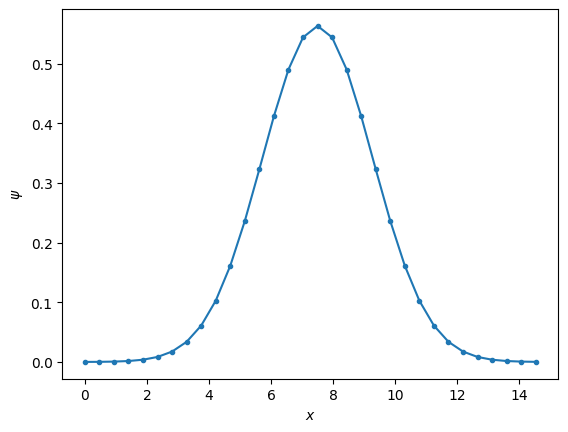

In [6]:
plt.plot(x_grid, psi_x, marker=".")
plt.ylabel("$\psi$")
plt.xlabel("$x$")

We can tensor these two of these together to form a 2D wavefunction - this is similar to if we have >1 particles. Note: electron wavefunctions aren't separable, so if you want to start with a 1-electron wavefunction in 2D/3D, you can't just tensor the 1D solutions together. But you CAN tensor together 1-electron wavefunctions to get an approx. of a 2-electron wavefunction.

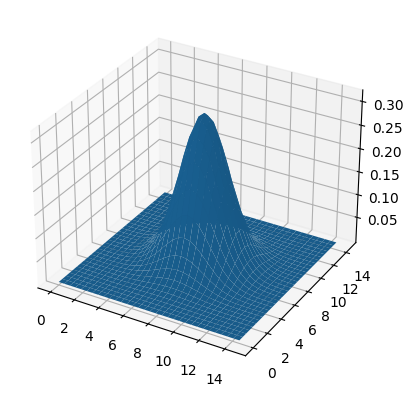

In [7]:
psi_2D = np.tensordot(psi_x, psi_x, axes=0)

X, Y = np.meshgrid(x_grid, x_grid)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X, Y, psi_2D)

In [8]:
# Check normalisation
np.sum(abs(psi_2D)**2)*dx**2

0.9999999931607289

In [9]:
# we normalise the wavefunction so that psi_2D itself sums to 1 on a quantum computer.
psi_2D = psi_2D * np.sqrt(dx**2)
np.sum(abs(psi_2D)**2)

0.9999999931607291

## 2. Loading into pyquest
We want to now load this into a pyquest quantum register. We need to flatten the state so that its a single vector.

In [10]:
from pyquest import Register

reg_init = Register(n_qubits + n_qubits) # 2x5 qubits!
reg_init[:] = psi_2D.flatten()

Our wavefunction is stored in qubits! The first 5 qubits correspond to x, the second 5 correspond to y. We can rescontruct the 2D wavefunction as a numpy array from the flattened version using `np.reshape`: this might be useful if you want to apply an operator that is not in pyquest - and you want to do it by multiplying a numpy array to a numpy array in python.

/home/hanschanhs/anaconda3/envs/pyquest-gpu/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


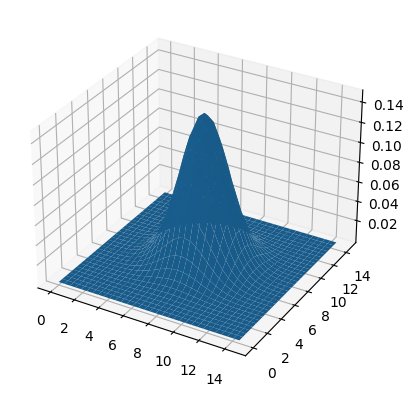

In [11]:
psi_recover = reg_init[:]
psi_recover = np.reshape(psi_recover, (2**n_qubits, 2**n_qubits)) 

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X, Y, psi_recover)

Something that might be even more useful is the probability distribution e.g. I have a 2 particle simulation, but I am only interested in the density of one of the particles. I can extract that very efficiently using a photo function in pyquest. Here I show and equivalent example where I only want the y-dimension of the 2D wavefunction - I provide the photo function with the index of the qubits which stores the y-dimension of the wavefunction (in the 10 qubit case, qubits 5-9).

Text(0.5, 0, '$x$')

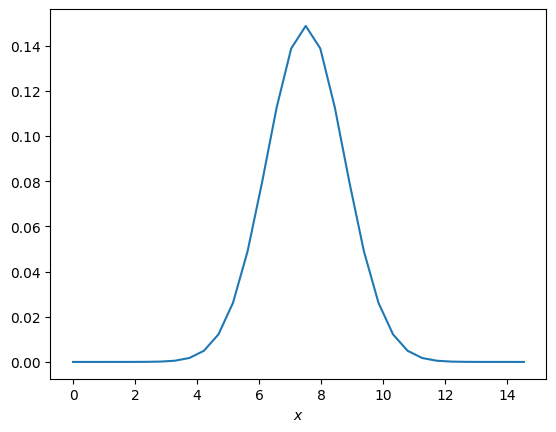

In [12]:
qubit_ids = [5, 6, 7, 8, 9]
density = reg_init.prob_of_all_outcomes(qubit_ids)

plt.plot(x_grid, density)
plt.xlabel("$x$")

## 3. Running a SO-QFT simulation using PhaseFunc and QFT
PyQuEST supports running Split-Operator simulations, by applying diagonal operators to specified qubits using PhaseFunc and implementing the QFT. 

I have included some basic functions for generating QFT circuits and Quadratic phase functions in `qarsen_lite`

In [13]:
from qarsen_lite.unitaries import gen_QFT_circ, gen_Quadratic_PhaseFunc

I include here functions which generates a second-order Trotter evolution sequence
\begin{equation}
    e^{-iH\Delta t} = e^{-iK\Delta t/2} e^{-iV\Delta t} e^{-iK\Delta t/2} + O(\Delta t^3)
\end{equation}

In [14]:
def gen_propagators(n_qubits, dx, xc, dt, m, k):
    """
    Specific for 1 particle in 2D harmonic potential, first order trotter - edit as necessary to generalise
    """
    # qubit targets
    init_qbit_idx = 0
    targets = []
    for _ in range(2):
        targets.append(list(range(init_qbit_idx, init_qbit_idx+n_qubits)))
        init_qbit_idx += n_qubits
    
    # QFT circuits
    cQFT_circs = [gen_QFT_circ(targets[d][0], targets[d][-1]) for d in range(2)]
    icQFT_circs = [circ.inverse for circ in cQFT_circs]
    # Kinetic propagator
    dp = 2*np.pi/(2**n_qubits * dx)
    pc = 2**n_qubits * dp / 2 # calculate the centre of the momentum space
    coeff = -dt/(2*m)
    K_props = [gen_Quadratic_PhaseFunc(targets[d], dp, 0.5*coeff, pc) for d in range(2)]

    # Potential 
    coeff = -k*dt/2
    V_props = [gen_Quadratic_PhaseFunc(targets[d], dx, coeff, xc) for d in range(2)]

    return targets, cQFT_circs, icQFT_circs, K_props, V_props

In [15]:
def apply_single_step(reg, qft_circs, iqft_circs, K_props, V_props):
    """
    """
    for qft in qft_circs:
        reg.apply_circuit(qft)
    for k in K_props:
        reg.apply_operator(k)
    for iqft in reversed(iqft_circs):
        reg.apply_circuit(iqft)
    
    for v in V_props:
        reg.apply_operator(v)

    for qft in qft_circs:
        reg.apply_circuit(qft)
    for k in K_props:
        reg.apply_operator(k)
    for iqft in reversed(iqft_circs):
        reg.apply_circuit(iqft)

We now write the full time evolution sequence:
\begin{equation}
    e^{-iHt} = \left( e^{-iH\Delta t} \right)^n
\end{equation}

In [16]:
from tqdm import tqdm

def U_RTE(reg_init, n_qubits, dx, t_tot, n_steps, xc, m, k, sample_every=10):
    """
    """
    dt = t_tot/n_steps # time resolution
    reg = Register(copy_reg=reg_init) # copy initial register
    targets, Qft, iQft, K, V = gen_propagators(n_qubits, dx, xc, dt, m, k) # generate propagators

    autocorrelation = []
    particle_density = []
    print("Running SO-QFT propagation...")
    for n in tqdm(range(n_steps)):
        apply_single_step(reg, Qft, iQft, K, V)

        # saving data
        if n%sample_every==0:
            autocorrelation.append(reg*reg_init)
            particle_density.append(reg.prob_of_all_outcomes(targets[1]))

    print("Done!")
    return autocorrelation, particle_density

In [17]:
t_tot = 100
n_steps = 8000
sample_every=80

k = 0.1

auto, particles = U_RTE(reg_init, n_qubits, dx, t_tot=t_tot, n_steps=n_steps, xc=L/2, m=1, k=k, sample_every=sample_every)

Running SO-QFT propagation...


100%|██████████| 8000/8000 [00:05<00:00, 1373.75it/s]

Done!


Text(0.5, 0, 't')

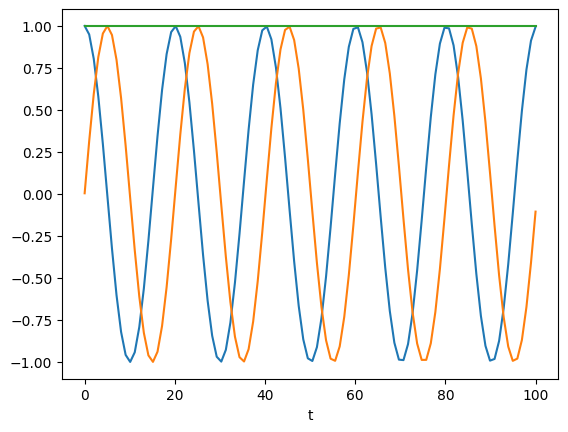

In [18]:
t_grid = np.linspace(0, t_tot, int(n_steps/sample_every))
plt.plot(t_grid, np.real(auto))
plt.plot(t_grid, np.imag(auto))
plt.plot(t_grid, np.abs(auto))
plt.xlabel("t")

We can animate the behaviour of the particle density - but it won't do anything because its a bound state.

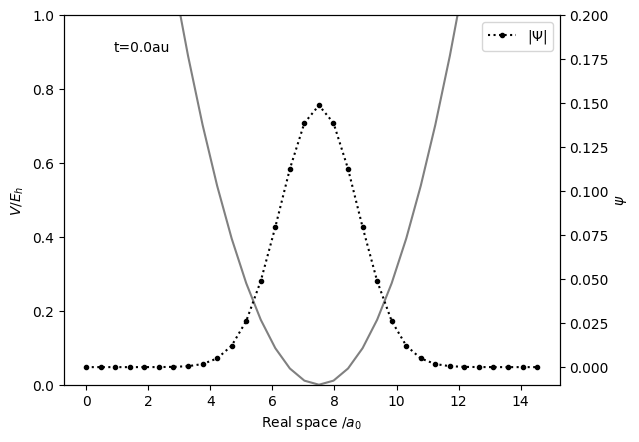

In [22]:
from qarsen_lite.animation import animate_1D_dynamics

anim = animate_1D_dynamics(x_grid=x_grid,
                            dyn=[particles],
                            t_grid=np.round(t_grid),
                            V_array=np.array([k/2*(x-L/2)**2 for x in x_grid]),
                            psi_ylim=(-0.01, 0.2)
                            )

In [23]:
from IPython.display import HTML

import matplotlib.animation as animation

writergif = animation.PillowWriter(fps=10)
anim.save('anim_harmonic.gif', writer=writergif)